In [1]:
%matplotlib inline
import glob
from fractions import Fraction
import itertools
import numpy as np
import numba as nb
import cv2
import matplotlib.pyplot as plt

In [2]:
root_dir = '/Users/kuang-yujeng/HDR_PJ/Test_Images/行政大樓_F8_ISO125_1o8_to_1o2048/'

In [3]:
image_list = glob.glob(root_dir+'*.JPG') + glob.glob(root_dir+'*.jpg')

In [4]:
def path2exposure(paths):
    ret = []
    for path in paths:
        exposure = list(map(int, ''.join(path.split('/')[-1].split('.')[:-1]).split(':')))
        if len(exposure) == 1:
            exposure.append(1)
        assert len(exposure) == 2, 'Name should be in fraction!'
        ret.append((Fraction(exposure[0],exposure[1]), path))
    ret.sort(key=lambda x: x[0])
    return ret

In [5]:
def exposure2imgs(exposure_paths):
    imgs = {}
    for exposure, path in exposure_paths:
        imgs[exposure] = cv2.imread(path, cv2.IMREAD_COLOR)[...,:3][...,::-1].astype(np.uint8) # BGR->RGB
    return imgs

In [6]:
def makeMTB(rgb, thresh=2):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    median = np.median(gray)
    MTB = (gray>median).astype(np.bool)
    ignore_mask = (gray<median+thresh).astype(np.bool) & (gray>median-thresh).astype(np.bool)
    return (MTB*255).astype(np.uint8), (ignore_mask*255).astype(np.uint8)

In [7]:
def next_power2(n):
    return int(2**np.ceil(np.log2(n)))

In [8]:
def translate_img(img, dx, dy):
    img_r = np.roll(np.roll(img, dy, axis=0), dx, axis=1)
    ignore_mask = np.zeros_like(img)
    if dy<0:
        img_r[dy:] = 0
        ignore_mask[dy:] = 255
    elif dy>0:
        img_r[:dy] = 0
        ignore_mask[:dy] = 255
    if dx<0:
        img_r[:,dx:] = 0
        ignore_mask[:,dx:] = 255
    elif dx>0:
        img_r[:,:dx] = 0
        ignore_mask[:,:dx] = 255
    return img_r, ignore_mask

In [9]:
def pyramidSearch(MTBs_w_mask, max_trans=30, reference_frame=None):
    # Input: MTBs_w_mask (list of tuples): [(mtb, ignore), (mtb, ignore), ...]
    #        reference_frame (integer): which picture we want to align to
    if reference_frame is None:
        reference_frame = len(MTBs_w_mask)//2
    n_levels = int(np.ceil(np.log2(max_trans)))
    H_ori, W_ori = MTBs_w_mask[0][0].shape[:2]
    
    ### Pad the original image ###
    # Pad Width if it is not power of 2
    pad_w = next_power2(W_ori) - W_ori if (W_ori & (W_ori-1) != 0) else 0
    pad_h = next_power2(H_ori) - H_ori if (H_ori & (H_ori-1) != 0) else 0
    
    if pad_w>0 or pad_h>0:
        padded = []
        for (mtb, ignore) in MTBs_w_mask:
            pad_mtb = np.pad(mtb, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=0)
            pad_ignore = np.pad(ignore, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=255)
            padded.append((pad_mtb, pad_ignore))
    else:
        padded = MTBs_w_mask
    
    H_pad, W_pad = padded[0][0].shape[:2]
    trans_x = [0]*len(padded)
    trans_y = [0]*len(padded)
    for l in reversed(range(0, n_levels)):
        step = int(2**l)
        H = H_pad//step
        W = W_pad//step
        if step == 1:
            resized = padded
        else:
            resized = []
            for mtb, ignore in padded:
                mtb_resize = np.where(cv2.resize(mtb, (W,H), interpolation=cv2.INTER_AREA)<128,0,255)
                ignore_resize = np.where(cv2.resize(ignore, (W,H), interpolation=cv2.INTER_AREA)<128,0,255)
                resized.append((mtb_resize, ignore_resize))
        mtb_r, ignore_r = resized[reference_frame]
        for n, (mtb, ignore) in enumerate(resized):
            if n == reference_frame: # self
                continue
            last_trans_x = trans_x[n]*2
            last_trans_y = trans_y[n]*2
            best = 0
            best_d = (0, 0) # order: x, y
            for dy, dx in itertools.product([0,1,-1],[0,1,-1]):
                shift_x = last_trans_x+dx
                shift_y = last_trans_y+dy
                mtb_patch = np.roll(np.roll(mtb, shift_y, axis=0), shift_x, axis=1)
                ignore_patch = np.roll(np.roll(ignore, shift_y, axis=0), shift_x, axis=1)
                if shift_y<0:
                    ignore_patch[shift_y:] = 255 # missing values due to translation
                elif shift_y>0:
                    ignore_patch[:shift_y] = 255
                if shift_x<0:
                    ignore_patch[:,shift_x:] = 255
                elif shift_x>0:
                    ignore_patch[:,:shift_x] = 255
                matched_n = np.sum((mtb_r==mtb_patch).astype(np.bool) & (~ignore_patch).astype(np.bool))
                if matched_n>best:
                    best = matched_n
                    best_d = (dx,dy)
            trans_x[n] = last_trans_x + best_d[0]
            trans_y[n] = last_trans_y + best_d[1]
    return trans_x, trans_y, reference_frame

In [10]:
exposure_paths = path2exposure(image_list)

In [11]:
imgs = exposure2imgs(exposure_paths)

In [12]:
MTBs_w_mask = [tuple(makeMTB(imgs[exposure])) for exposure in sorted(list(imgs))]

In [13]:
trans_x, trans_y, reference_frame = pyramidSearch(MTBs_w_mask)

In [14]:
trans_x, trans_y

([-5, -5, 7, 7, 0, 7, 3, -11, 1], [11, 9, 8, 8, 0, 8, 1, 2, 1])

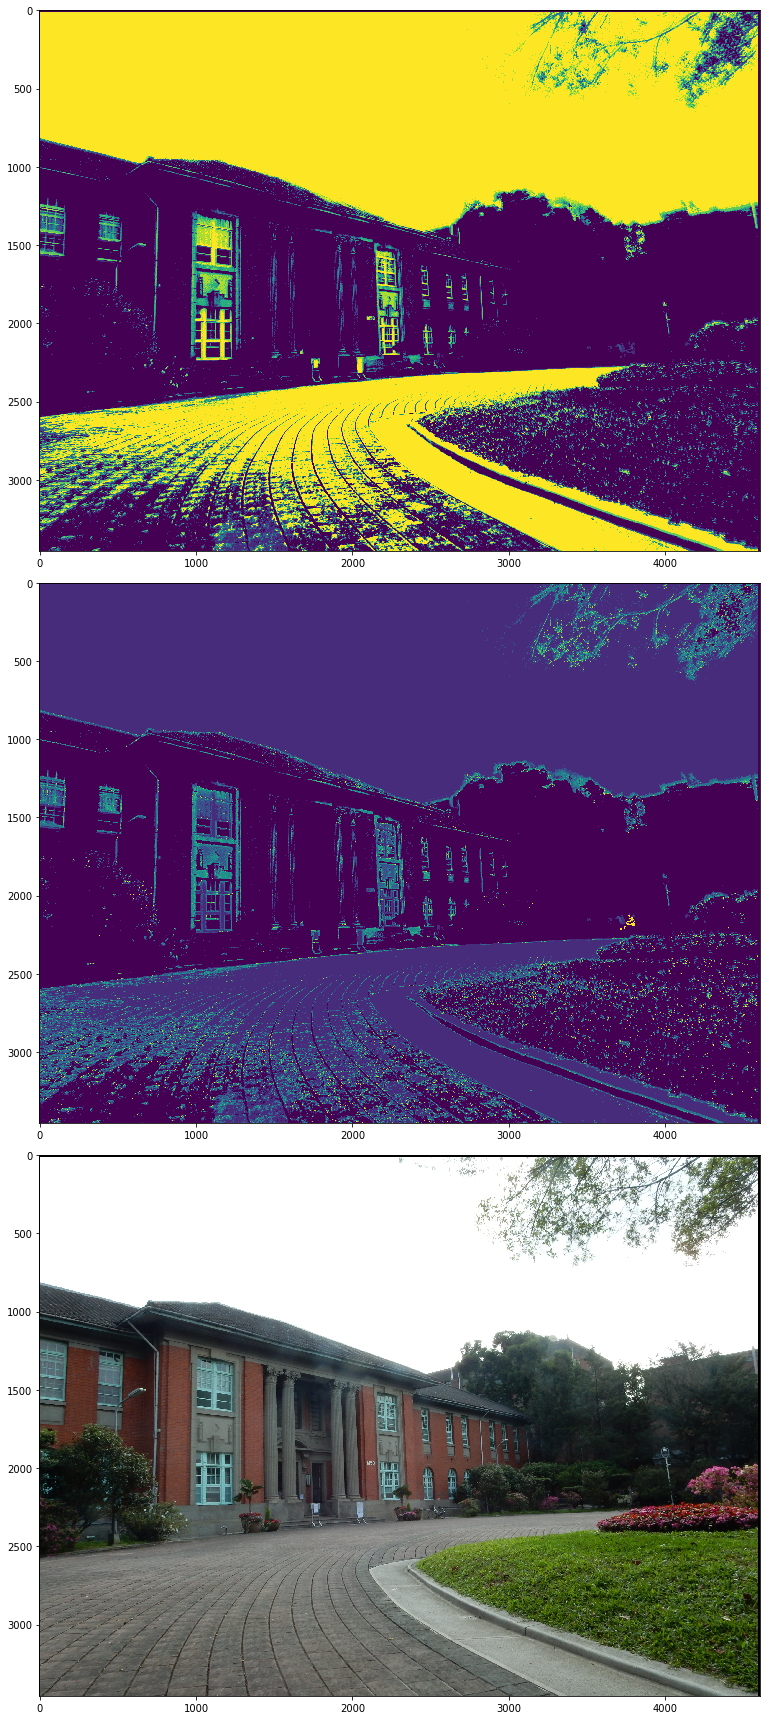

In [15]:
rgb_imgs = []
mtb_imgs = []
mtb_r = MTBs_w_mask[reference_frame][0]
diff_img = np.zeros_like(mtb_r, dtype=np.float32)
ignore = None
for n, (mtb, _), rgb_key in zip(range(len(MTBs_w_mask)), MTBs_w_mask, sorted(list(imgs))):
    rgb = imgs[rgb_key]
    mtb_shifted, ignore_area = translate_img(mtb, trans_x[n], trans_y[n])
    rgb_shifted, _ = translate_img(rgb, trans_x[n], trans_y[n])
    mtb_imgs.append(mtb_shifted)
    rgb_imgs.append(rgb_shifted)
    ignore = ignore_area if ignore is None else (ignore_area | ignore)
    diff_img[mtb_shifted!=mtb_r] += 1
mtb_imgs = np.mean(mtb_imgs, axis=0)
rgb_imgs = np.median(rgb_imgs, axis=0).astype(np.uint8)
mtb_imgs[ignore>0] = 0
rgb_imgs[ignore>0] = 0
diff_img[ignore>0] = 0
mtb_imgs = mtb_imgs / mtb_imgs.max()
diff_img = diff_img / diff_img.max()
fig, ax = plt.subplots(3, 1, figsize=[6.4*5, 4.8*5])
ax[0].imshow(mtb_imgs)
ax[1].imshow(diff_img)
ax[2].imshow(rgb_imgs)
plt.tight_layout()
plt.show()